<a href="https://colab.research.google.com/github/mir4gee/Open_Project_Finance-Stock-Sentiment-Analysis-Using-ML/blob/main/Final_GOOG_Open_Project_Stock_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Sentiment Analysis Using Machine Learning (#FC24OPS3)**

## Installation and Import

In [1]:
! pip install textblob
! pip install vaderSentiment
! pip install scikit-learn
! pip install yfinance
! pip install nltk spacy
! pip install requests beautifulsoup4 pandas
! pip install transformers

In [2]:
import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
import time

import requests
from bs4 import BeautifulSoup
import csv
from textblob import TextBlob
import re
from collections import defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import yfinance as yf
import os
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Collection & Pre-Processing

In [4]:
def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    lemmatizer = WordNetLemmatizer()
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in stemmed_tokens]

    return " ".join(lemmatized_tokens)

In [5]:
api_key = 'KPdZEAPGHoazqGaFckkGm1dNlCxULV85'

sections_to_include = [
    "Corrections", "New York", "International Home", "U.S.", "Business Day",
    "Real Estate", "World", "Times Insider", "T Magazine",
    "Technology", "Magazine", "Your Money", "Obituaries"
]

articles_by_date = defaultdict(list)
for year in range(2003, 2024):

    for month in range(1, 13):
        url = f"https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={api_key}"
        print(url)
        response = requests.get(url)
        # print(response)

        if response.status_code == 200:
            data = response.json()
            # print(f"Status code: {response.status_code}")

            for article in data['response']['docs']:
                section_name = article['section_name']
                if section_name in sections_to_include:
                    date = article['pub_date'][:10]
                    headline = article['headline']['main']
                    articles_by_date[date].append(headline)

        else:
            print(f"Failed API. Status code: {response.status_code}")
        time.sleep(12)

with open(f'nyt_articles.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Date', 'Headlines'])

    for date, headlines in articles_by_date.items():
        joined_headlines = " ".join(headlines)
        writer.writerow([date, preprocess_text(joined_headlines)])

# In the main code I have not used this multiple times and only used this once to get the simple file.
# The file is nyt_articles_io.csv which came using this code.


In [6]:
df1 = pd.read_csv('drive/MyDrive/nyt_articles_io.csv')
df1.head()
df1.shape
df1

,Date,Headlines
0,2003-01-01,pataki inaugur address one fortunetel unforese...
1,2003-01-02,master key con digit brio quotat day pact lift...
2,2003-01-03,world busi brief asia china trade volum grow l...
3,2003-01-04,poor woman go castl besieg dr eleanor j gibson...
4,2003-01-05,compani insid year sidelin u su air rule perso...
...,...,...
7664,2023-12-27,michael flynn rhode island hall fame inclus pr...
7665,2023-12-28,herbert kohl former wisconsin senat milwauke b...
7666,2023-12-29,main join colorado find trump inelig primari b...
7667,2023-12-30,trump team prepar file challeng ballot decis s...


In [7]:
ticker_symbol = "GOOG"
start_date = "2024-01-01"
end_date = "2024-05-31"

sp500 = yf.Ticker(ticker_symbol)
sp500_data = sp500.history(period="max")
sp500_data.reset_index(inplace=True)
sp500_data['Date'] = sp500_data['Date'].dt.date

<Axes: xlabel='Date'>

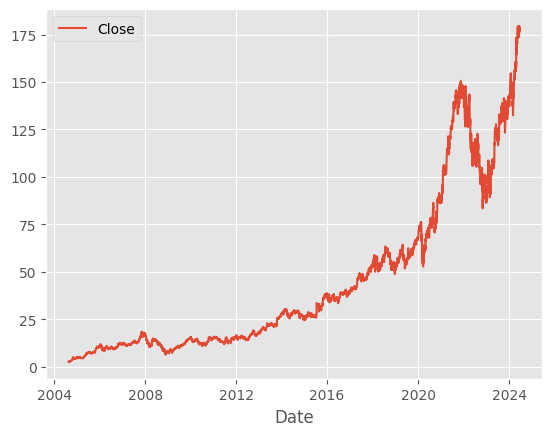

In [8]:
sp500_jan_2023=sp500_data
sp500_jan_2023.plot.line(y="Close",x='Date',use_index=True)

In [9]:
sp500_jan_2023["Yesterday"] = sp500_jan_2023["Close"].shift(1)
sp500_jan_2023["Tomorrow"] = sp500_jan_2023["Close"].shift(-1)
sp500_jan_2023["Label(Up/Down)"] = (sp500_jan_2023["Tomorrow"] > sp500_jan_2023["Close"]).astype(int)


label_changes = sp500_jan_2023["Label(Up/Down)"] != sp500_jan_2023["Label(Up/Down)"].shift(1)
group_id = label_changes.cumsum()
sp500_jan_2023["Cumu_Label(Up/Down)"] = sp500_jan_2023.groupby(group_id).cumcount()
sp500_jan_2023["Cumu_Label(Up/Down)"] = sp500_jan_2023.apply(
    lambda row: row["Cumu_Label(Up/Down)"] if row["Label(Up/Down)"] == 1 else -row["Cumu_Label(Up/Down)"],
    axis=1
)
sp500_jan_2023.dropna(inplace=True)

sp500_jan_2023.to_csv('sp500_jan_2023.csv', index=False)
sp500_jan_2023

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Yesterday,Tomorrow,Label(Up/Down),Cumu_Label(Up/Down)
1,2004-08-20,2.512960,2.713729,2.500273,2.694573,458857488,0.0,0.0,2.496292,2.721690,1,1
2,2004-08-23,2.755276,2.823193,2.712983,2.721690,366857939,0.0,0.0,2.694573,2.608991,0,0
3,2004-08-24,2.767466,2.776422,2.576649,2.608991,306396159,0.0,0.0,2.721690,2.637103,1,0
4,2004-08-25,2.611230,2.686860,2.584361,2.637103,184645512,0.0,0.0,2.608991,2.684621,1,1
5,2004-08-26,2.610981,2.685616,2.603766,2.684621,142572401,0.0,0.0,2.637103,2.640835,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4986,2024-06-11,177.720001,178.389999,175.440002,178.190002,14402400,0.0,0.0,176.630005,179.559998,1,2
4987,2024-06-12,179.750000,182.080002,177.779999,179.559998,18600400,0.0,0.0,178.190002,176.740005,0,0
4988,2024-06-13,177.839996,178.509995,176.660004,176.740005,15956900,0.0,0.0,179.559998,178.369995,1,0
4989,2024-06-14,175.852005,178.729996,175.852005,178.369995,12361600,0.0,0.0,176.740005,178.779999,1,1


In [10]:
df2 = pd.read_csv('sp500_jan_2023.csv')
for window in [2,5,60,250,500]:
    df2[f'RollingMean_{window}'] = df2['Close'].rolling(window=window).mean()
    df2[f'RollingStd_{window}'] = df2['Close'].rolling(window=window).std()
    df2[f'Momentum_{window}'] = df2['Close'].diff(window)

df2 = df2.fillna(0)

In [11]:
df_subset = df2.iloc[249:]

In [12]:
merged_df = pd.merge(df1, df_subset, on='Date')

## Sentiment Analysis & Coorelation with Stocks

In [13]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity
def getSIA(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment

In [14]:
merged_df['Subjectivity'] = merged_df['Headlines'].apply(getSubjectivity)
merged_df['Polarity'] = merged_df['Headlines'].apply(getPolarity)
compound = []
neg = []
pos = []
neu = []
SIA = 0
for i in range(0, len(merged_df['Headlines'])):
    SIA = getSIA(merged_df['Headlines'][i])
    compound.append(SIA['compound'])
    neg.append(SIA['neg'])
    neu.append(SIA['neu'])
    pos.append(SIA['pos'])

merged_df['Compound'] = compound
merged_df['Negative'] = neg
merged_df['Neutral'] = neu
merged_df['Positive'] = pos

merged_df

,Date,Headlines,Open,High,Low,Close,Volume,Dividends,Stock Splits,Yesterday,...,Momentum_250,RollingMean_500,RollingStd_500,Momentum_500,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2005-08-16,mayor thorn citi council use low expect indone...,7.087340,7.159736,7.049027,7.106496,285433881,0.0,0.0,7.065447,...,0.000000,0.000000,0.000000,0.000000,0.402246,0.044216,-0.9991,0.190,0.737,0.073
1,2005-08-17,close argument wednesday vioxx lawsuit texa wo...,7.103013,7.129384,7.065447,7.092813,155914222,0.0,0.0,7.106496,...,4.398240,0.000000,0.000000,0.000000,0.355918,-0.002397,-0.9995,0.218,0.745,0.037
2,2005-08-18,juror vioxx trial hear close argument germani ...,6.864181,6.978373,6.841542,6.965684,476692087,0.0,0.0,7.092813,...,4.243994,0.000000,0.000000,0.000000,0.379065,0.046255,-0.9993,0.198,0.725,0.077
3,2005-08-19,rule restor lose benefit immigr billion deal m...,6.990563,7.002007,6.956480,6.965933,222547046,0.0,0.0,6.965684,...,4.356942,0.000000,0.000000,0.000000,0.379817,0.075370,-0.9979,0.173,0.734,0.092
4,2005-08-22,googl plan tospend billion wireless chip ride ...,6.996782,7.002504,6.800492,6.816912,273541472,0.0,0.0,6.965933,...,4.179809,0.000000,0.000000,0.000000,0.344917,0.009004,-0.9974,0.186,0.730,0.084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4619,2023-12-22,u prepar lift ban sale offens weapon saudi ara...,141.968444,143.087166,141.893517,142.557770,18494700,0.0,0.0,141.638824,...,52.849854,117.241195,16.331534,-3.723770,0.346313,0.069688,-0.9738,0.145,0.736,0.118
4620,2023-12-26,u strike iranback group iraq attack base injur...,142.817476,143.781390,142.338025,142.657669,11170100,0.0,0.0,142.557770,...,54.827614,117.233834,16.319219,-3.680313,0.294114,0.046984,-0.9741,0.173,0.764,0.063
4621,2023-12-27,michael flynn rhode island hall fame inclus pr...,142.667655,143.157104,140.890670,141.279236,17288400,0.0,0.0,142.657669,...,54.917511,117.224720,16.304477,-4.557312,0.405104,-0.012241,-0.9971,0.236,0.693,0.072
4622,2023-12-28,herbert kohl former wisconsin senat milwauke b...,141.688775,142.108296,140.667933,141.119415,12192500,0.0,0.0,141.279236,...,52.270523,117.217928,16.293791,-3.395645,0.315618,0.021329,-0.9952,0.198,0.748,0.054


In [15]:
merged_df.to_csv('merged_df.csv', index=False)

In [16]:
final_df = merged_df[["Open", "High", "Low", "Close", "Volume" ,"Yesterday","Subjectivity", "Polarity", "Compound", "Negative", "Neutral", "Positive","Cumu_Label(Up/Down)","Label(Up/Down)"]]
final_df.insert(0, 'Index', range(1, 1 + len(final_df)))

In [17]:
results_df = final_df
headers = results_df.columns.tolist()
headers

['Index',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Yesterday',
 'Subjectivity',
 'Polarity',
 'Compound',
 'Negative',
 'Neutral',
 'Positive',
 'Cumu_Label(Up/Down)',
 'Label(Up/Down)']

In [18]:
for window in [2,5,60,250,500]:
    results_df[f'RollingMean_{window}'] = results_df['Close'].rolling(window=window).mean()
    results_df[f'RollingStd_{window}'] = results_df['Close'].rolling(window=window).std()
    results_df[f'Momentum_{window}'] = results_df['Close'].diff(window)

results_df = results_df.fillna(0)

<ipython-input-18-ddfcf4c3dbd4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df[f'RollingMean_{window}'] = results_df['Close'].rolling(window=window).mean()
<ipython-input-18-ddfcf4c3dbd4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df[f'RollingStd_{window}'] = results_df['Close'].rolling(window=window).std()
<ipython-input-18-ddfcf4c3dbd4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [19]:
results_df

,Index,Open,High,Low,Close,Volume,Yesterday,Subjectivity,Polarity,Compound,...,Momentum_5,RollingMean_60,RollingStd_60,Momentum_60,RollingMean_250,RollingStd_250,Momentum_250,RollingMean_500,RollingStd_500,Momentum_500
0,1,7.087340,7.159736,7.049027,7.106496,285433881,7.065447,0.402246,0.044216,-0.9991,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,7.103013,7.129384,7.065447,7.092813,155914222,7.106496,0.355918,-0.002397,-0.9995,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,6.864181,6.978373,6.841542,6.965684,476692087,7.092813,0.379065,0.046255,-0.9993,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,6.990563,7.002007,6.956480,6.965933,222547046,6.965684,0.379817,0.075370,-0.9979,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,6.996782,7.002504,6.800492,6.816912,273541472,6.965933,0.344917,0.009004,-0.9974,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4619,4620,141.968444,143.087166,141.893517,142.557770,18494700,141.638824,0.346313,0.069688,-0.9738,...,8.869904,135.072293,4.628356,9.579086,118.619277,16.582600,52.849854,117.241195,16.331534,-3.723770
4620,4621,142.817476,143.781390,142.338025,142.657669,11170100,142.557770,0.294114,0.046984,-0.9741,...,5.623611,135.254919,4.708529,10.957535,118.838587,16.536259,54.827614,117.233834,16.319219,-3.680313
4621,4622,142.667655,143.157104,140.890670,141.279236,17288400,142.657669,0.405104,-0.012241,-0.9971,...,3.336197,135.359300,4.772141,6.262878,119.058258,16.467723,54.917511,117.224720,16.304477,-4.557312
4622,4623,141.688775,142.108296,140.667933,141.119415,12192500,141.279236,0.315618,0.021329,-0.9952,...,1.618164,135.492149,4.820258,7.970932,119.267340,16.414369,52.270523,117.217928,16.293791,-3.395645


## Predictive Modeling and Visualization

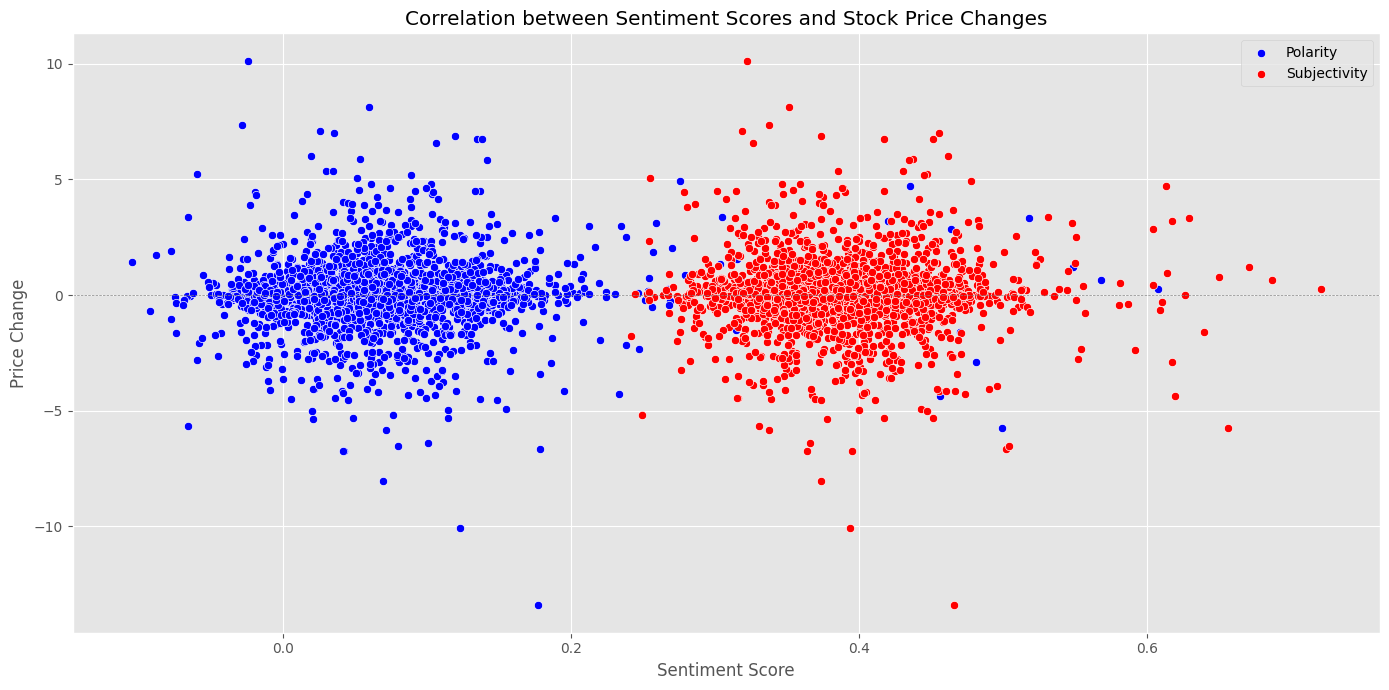

In [20]:
merged_df['PriceChange'] = merged_df['Close'].diff()
merged_df.dropna(inplace=True)

plt.figure(figsize=(14, 7))

sns.scatterplot(x=merged_df['Polarity'], y=merged_df['PriceChange'], color='blue', label='Polarity')

sns.scatterplot(x=merged_df['Subjectivity'], y=merged_df['PriceChange'], color='red', label='Subjectivity')

plt.title('Correlation between Sentiment Scores and Stock Price Changes')
plt.xlabel('Sentiment Score')
plt.ylabel('Price Change')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


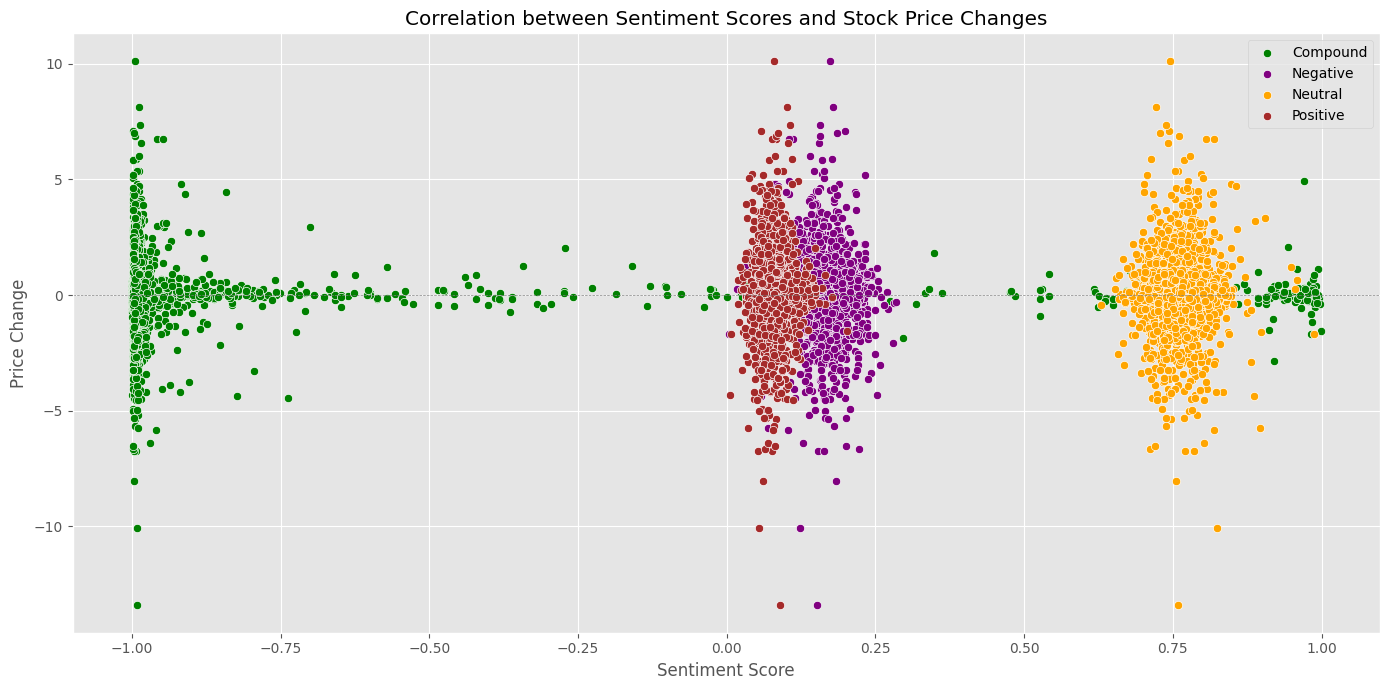

In [21]:

sentiment_scores = ['Compound', 'Negative', 'Neutral', 'Positive']
colors = ['green', 'purple', 'orange', 'brown']

plt.figure(figsize=(14, 7))

for score, color in zip(sentiment_scores, colors):
    sns.scatterplot(x=merged_df[score], y=merged_df['PriceChange'], color=color, label=score)

plt.title('Correlation between Sentiment Scores and Stock Price Changes')
plt.xlabel('Sentiment Score')
plt.ylabel('Price Change')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
predictors = [
 'Index',
 'Open',
 'Close',
 'Volume',
 'Subjectivity',
 'Polarity',
 'Compound',
 'Negative',
 'Neutral',
 'Positive',
 'Yesterday',
 'RollingMean_2',
 'RollingStd_2',
 'Momentum_2',
 'RollingMean_5',
 'RollingStd_5',
 'Momentum_5',
 'RollingMean_60',
 'RollingStd_60',
 'Momentum_60',
 'RollingMean_250',
 'RollingStd_250',
 'Momentum_250',
]
feauture = results_df[predictors]
target = results_df["Label(Up/Down)"]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(feauture, target, test_size=0.2, random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
precision_lda = precision_score(y_test, y_pred_lda, average='weighted', zero_division=1)
accuracy_lda = accuracy_score(y_test, y_pred_lda,normalize=True)

print('Linear Regression')
print(classification_report(y_test, y_pred_lda))
print(f"Precision Score (weighted): {precision_lda}")
print(f"Accuracy Score (weighted): {accuracy_lda}")


# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted', zero_division=1)
accuracy_lr = accuracy_score(y_test, y_pred_lr,normalize=True)

print('Logistic Regression')
print(classification_report(y_test, y_pred_lr))
print(f"Precision Score (weighted): {precision_lr}")
print(f"Accuracy Score (weighted): {accuracy_lr}")


# SVM
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=1)
accuracy_svm = accuracy_score(y_test, y_pred_svm,normalize=True)

print('SVM')
print(classification_report(y_test, y_pred_svm))
print(f"Precision Score (weighted): {precision_svm}")
print(f"Accuracy Score (weighted): {accuracy_svm}")


# Random Forest
rf = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=1)
accuracy_rf = accuracy_score(y_test, y_pred_rf,normalize=True)

print('Random Forest')
print(classification_report(y_test, y_pred_rf))
print(f"Precision Score (weighted): {precision_rf}")
print(f"Accuracy Score (weighted): {accuracy_rf}")

# Neural Network
nn = MLPClassifier(max_iter=5000)
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
precision_nn = precision_score(y_test, y_pred_nn, average='weighted', zero_division=1)
accuracy_nn = accuracy_score(y_test, y_pred_nn,normalize=True)

print('Neural Network')
print(classification_report(y_test, y_pred_nn))
print(f"Precision Score (weighted): {precision_nn}")
print(f"Accuracy Score (weighted): {accuracy_nn}")

y_pred_avg = np.round((y_pred_lda + y_pred_lr + y_pred_svm + y_pred_rf + y_pred_nn) / 5)

precision_avg = precision_score(y_test, y_pred_avg, average='weighted', zero_division=1)
accuracy_avg = accuracy_score(y_test, y_pred_avg,normalize=True)

print('Average of All Classifiers')
print(classification_report(y_test, y_pred_avg))
print(f"Precision Score (weighted): {precision_avg}")
print(f"Accuracy Score (weighted): {accuracy_avg}")

Linear Regression
              precision    recall  f1-score   support

           0       0.50      0.23      0.31       457
           1       0.51      0.77      0.61       468

    accuracy                           0.50       925
   macro avg       0.50      0.50      0.46       925
weighted avg       0.50      0.50      0.46       925

Precision Score (weighted): 0.5008627635812796
Accuracy Score (weighted): 0.5037837837837837
Logistic Regression
              precision    recall  f1-score   support

           0       0.50      0.23      0.31       457
           1       0.51      0.77      0.61       468

    accuracy                           0.50       925
   macro avg       0.50      0.50      0.46       925
weighted avg       0.50      0.50      0.47       925

Precision Score (weighted): 0.502372294633237
Accuracy Score (weighted): 0.5048648648648648
SVM
              precision    recall  f1-score   support

           0       0.51      0.15      0.24       457
          

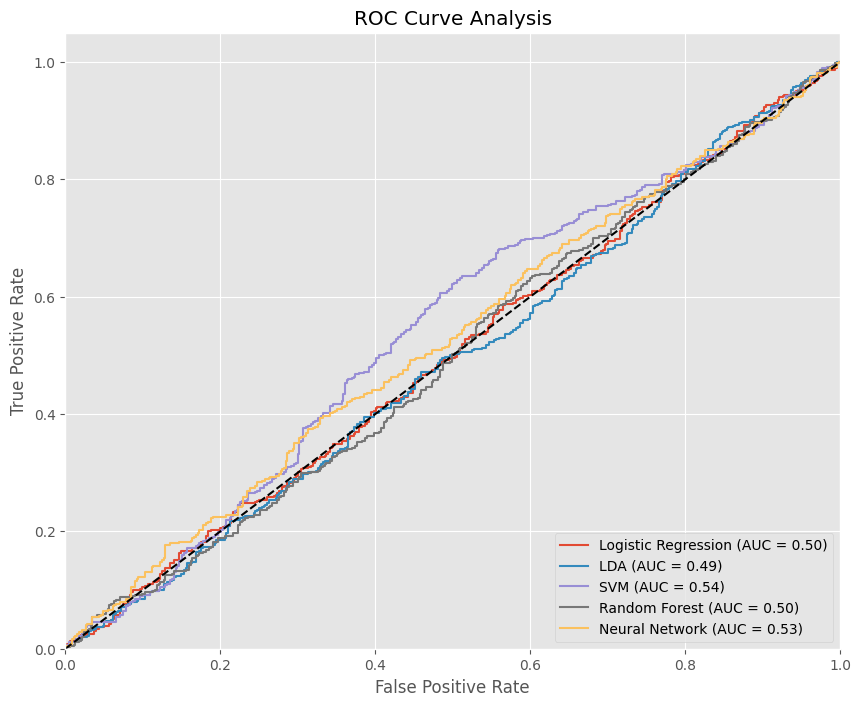

In [25]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'LDA': LinearDiscriminantAnalysis(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=0),
    'Neural Network': MLPClassifier(max_iter=5000)
}

plt.figure(figsize=(10, 8))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)[:, 1]
    else:
        y_score = clf.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Analysis')
plt.legend(loc='lower right')
plt.show()

## Model Run on Jan-May 2024 with Deliverables

### Data Collection for Prediction

In [26]:
feauture = results_df[predictors]
target = results_df["Label(Up/Down)"]

In [27]:
p=pd.read_csv('drive/MyDrive/nyt_articles_jan.csv')

In [28]:
p['Subjectivity'] = p['Headlines'].apply(getSubjectivity)
p['Polarity'] = p['Headlines'].apply(getPolarity)
compound = []
neg = []
pos = []
neu = []
SIA = 0
for i in range(0, len(p['Headlines'])):
    SIA = getSIA(p['Headlines'][i])
    compound.append(SIA['compound'])
    neg.append(SIA['neg'])
    neu.append(SIA['neu'])
    pos.append(SIA['pos'])

p['Compound'] = compound
p['Negative'] = neg
p['Neutral'] = neu
p['Positive'] = pos

p

,Date,Headlines,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2024-01-01,pga tour saudiback liv extend deadlin final de...,0.398362,0.107614,-0.9729,0.148,0.754,0.098
1,2024-01-02,ana ofelia murgua mexican actress voic coco di...,0.421561,0.106231,-0.9964,0.166,0.746,0.088
2,2024-01-03,epstein document name promin figur expect rele...,0.375262,0.144959,-0.9991,0.210,0.714,0.076
3,2024-01-04,persecut harvard claudin gay unseal document s...,0.433273,0.088903,-0.9969,0.168,0.733,0.100
4,2024-01-05,ron desanti nikki haley polit obtus plutocrat ...,0.384068,0.164382,-0.9982,0.165,0.751,0.084
...,...,...,...,...,...,...,...,...
147,2024-05-27,nicki minaj apolog postpon show video appear s...,0.502849,0.043982,-0.8251,0.141,0.741,0.118
148,2024-05-28,trump lawyer assail limit gag order request do...,0.454247,0.189529,-0.9973,0.150,0.771,0.079
149,2024-05-29,juri texa state hous st district primari runof...,0.381839,0.062810,-0.9962,0.141,0.782,0.076
150,2024-05-30,activist investor nelson peltz say sell disney...,0.478065,0.156761,-0.4188,0.113,0.770,0.117


In [29]:
merge2=pd.merge(p, df2, on='Date')
merge2.insert(0, 'Index', range(4874, 4874 + len(merge2)))

### Model Prediction and Further Analysis

In [30]:
feauture2 = merge2[predictors]
target2 = merge2["Label(Up/Down)"]

In [31]:
(X_test2, y_test2)=(feauture2, target2)
scaler = StandardScaler()
X_test2 = scaler.fit_transform(X_test2)

In [32]:
y_pred_lda = lda.predict(X_test2)
precision_lda = precision_score(y_test2, y_pred_lda, average='weighted', zero_division=1)

print('Linear Regression')
print(classification_report(y_test2, y_pred_lda))
print(f"Precision Score (weighted): {precision_lda}")


y_pred_lr = lr.predict(X_test2)
precision = precision_score(y_test2, y_pred_lr, average='weighted', zero_division=1)

print('Logistic Regression')
print(classification_report(y_test2, y_pred_lr))
print(f"Precision Score (weighted): {precision}")


y_pred_svm = svm.predict(X_test2)
precision_svm = precision_score(y_test2, y_pred_svm, average='weighted', zero_division=1)

print('SVM')
print(classification_report(y_test2, y_pred_svm))
print(f"Precision Score (weighted): {precision_svm}")


y_pred_rf = rf.predict(X_test2)
precision_rf = precision_score(y_test2, y_pred_rf, average='weighted', zero_division=1)

print('Random Forest')
print(classification_report(y_test2, y_pred_rf))
print(f"Precision Score (weighted): {precision_rf}")



y_pred_nn = nn.predict(X_test2)
precision_nn = precision_score(y_test2, y_pred_nn, average='weighted', zero_division=1)

print('Neural Network')
print(classification_report(y_test2, y_pred_nn))
print(f"Precision Score (weighted): {precision_nn}")


y_pred_avg = np.round((y_pred_lda + y_pred_lr + y_pred_svm + y_pred_rf + y_pred_nn) / 5)
from sklearn.metrics import classification_report, precision_score


precision_avg = precision_score(y_test2, y_pred_avg, average='weighted', zero_division=1)

print('Average of All Classifiers')
print(classification_report(y_test2, y_pred_avg))
print(f"Precision Score (weighted): {precision_avg}")

Linear Regression
              precision    recall  f1-score   support

           0       0.33      0.41      0.36        39
           1       0.59      0.50      0.54        66

    accuracy                           0.47       105
   macro avg       0.46      0.46      0.45       105
weighted avg       0.49      0.47      0.48       105

Precision Score (weighted): 0.4916909620991254
Logistic Regression
              precision    recall  f1-score   support

           0       0.36      0.41      0.38        39
           1       0.62      0.56      0.59        66

    accuracy                           0.50       105
   macro avg       0.49      0.49      0.48       105
weighted avg       0.52      0.50      0.51       105

Precision Score (weighted): 0.5196825396825397
SVM
              precision    recall  f1-score   support

           0       0.42      0.36      0.39        39
           1       0.65      0.71      0.68        66

    accuracy                           0.58   

In [33]:
y_pred_avg = ((y_pred_lda) + (1*y_pred_lr) + (y_pred_svm)+2*y_pred_rf+1*y_pred_nn) / 6

threshold = 0.5
y_pred_avg_binary = (y_pred_avg >= threshold).astype(int)

precision_avg = precision_score(y_test2, y_pred_avg_binary, average='weighted', zero_division=1)

print('Weighted Average of All Classifiers')
print(classification_report(y_test2, y_pred_avg_binary))
print(f"Weighted Precision Score: {precision_avg}")


Weighted Average of All Classifiers
              precision    recall  f1-score   support

           0       0.47      0.41      0.44        39
           1       0.68      0.73      0.70        66

    accuracy                           0.61       105
   macro avg       0.57      0.57      0.57       105
weighted avg       0.60      0.61      0.60       105

Weighted Precision Score: 0.5997396141555214


In [34]:
merge2['y_pred_avg_binary'] = y_pred_avg_binary

In [35]:
label_changes = merge2["y_pred_avg_binary"] != merge2["y_pred_avg_binary"].shift(1)

group_id = label_changes.cumsum()

merge2["Cumu_Label(Up/Down)"] = merge2.groupby(group_id).cumcount()

merge2["Cumu_Label(Up/Down)"] = merge2.apply(
    lambda row: row["Cumu_Label(Up/Down)"] if row["y_pred_avg_binary"] == 1 else -row["Cumu_Label(Up/Down)"],
    axis=1
)

In [36]:
merge2['Diff'] = merge2['Cumu_Label(Up/Down)'].diff()

def generate_signal(row):
    if row['Diff'] > 0 and row['Cumu_Label(Up/Down)'] ==1:
        return "Buy"
    elif row['Diff'] <= -1 and row['Cumu_Label(Up/Down)'] ==-1:
        return "Sell"
    else:
        return "Hold"

merge2['Signal'] = merge2.apply(generate_signal, axis=1)

merge2.dropna(subset=['Diff'], inplace=True)

In [37]:
buy_signals = merge2[merge2['Signal'] == 'Buy']
sell_signals = merge2[merge2['Signal'] == 'Sell']

In [38]:
last_close = merge2['Close'].iloc[-1]
first_close = merge2['Close'].iloc[0]
buy_signals['Value_Change'] = last_close - buy_signals['Close']
sell_signals['Value_Change'] = last_close - sell_signals['Close']

<ipython-input-38-6aad0fc41dfa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_signals['Value_Change'] = last_close - buy_signals['Close']
<ipython-input-38-6aad0fc41dfa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_signals['Value_Change'] = last_close - sell_signals['Close']


In [39]:
total_buy_value_change = buy_signals['Value_Change'].sum()
total_sell_value_change = sell_signals['Value_Change'].sum()

total_value_change = total_buy_value_change - total_sell_value_change
total_value_ = last_close - first_close

### Buy/Sell Chart and Cumulative Return Over Time

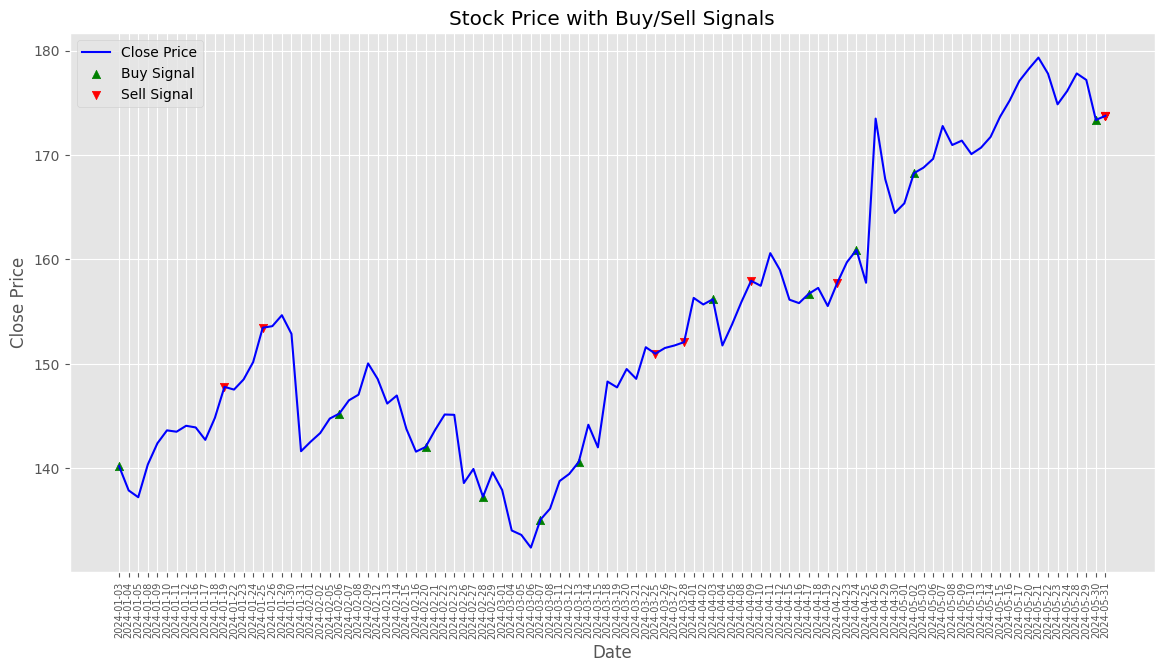

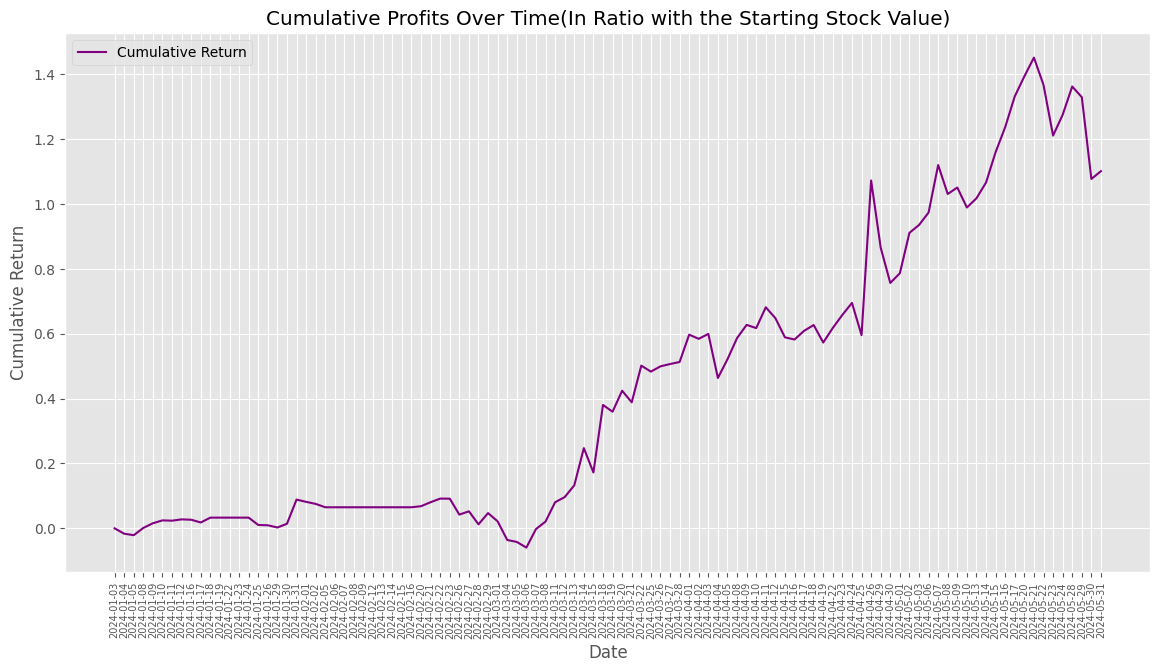

In [40]:
holding_flag = 0

merge2['Holding'] = False

for index, row in merge2.iterrows():
    if row['Signal'] == "Buy":
        holding_flag += 1
    elif row['Signal'] == "Sell":
        holding_flag -= 1

    merge2.at[index, 'Holding'] = holding_flag

rows_to_append = []

mm = int(merge2.iloc[-1]['Holding'])
while(mm>0):
    new_row = merge2.iloc[-1].copy()
    new_row['Signal'] = 'Sell'
    rows_to_append.append(new_row.to_dict())
    mm= mm-1

merge2 = pd.concat([merge2, pd.DataFrame(rows_to_append)])


merge2['Daily_Return'] = merge2['Close'].pct_change()
merge2['Holding_Return'] = merge2['Daily_Return'] * merge2['Holding']
merge2['Holding_Return'].fillna(0, inplace=True)
merge2['Cumulative_Return'] = (1 + merge2['Holding_Return']).cumprod()
merge2['Excess_Holding_Return'] = merge2['Holding_Return']

plt.figure(figsize=(14, 7))
plt.plot(merge2['Date'], merge2['Close'], label='Close Price', color='blue')

buy_signals = merge2[merge2['Signal'] == 'Buy']
plt.scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)

sell_signals = merge2[merge2['Signal'] == 'Sell']
plt.scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.title('Stock Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=90, fontsize=7)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(merge2['Date'], merge2['Cumulative_Return']-1, label='Cumulative Return', color='purple')
plt.title('Cumulative Profits Over Time(In Ratio with the Starting Stock Value)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.xticks(rotation=90, fontsize=7)
plt.show()

In [41]:
merge2['Cumulative_Return'] = (1 + merge2['Holding_Return']).cumprod()
merge2['Running_Max'] = merge2['Cumulative_Return'].cummax()
merge2['Drawdown'] = merge2['Cumulative_Return'] / merge2['Running_Max'] - 1
max_drawdown = merge2['Drawdown'].min()

In [42]:
# buy_signals.shape == sell_signals.shape

### Deliverables

In [43]:
num_trades = buy_signals.shape[0]

min_trades = min(len(buy_signals), len(sell_signals))
buy_signals = buy_signals.iloc[:min_trades]
sell_signals = sell_signals.iloc[:min_trades]

trades = pd.DataFrame({
    'Buy_Date': buy_signals['Date'].values,
    'Sell_Date': sell_signals['Date'].values,
    'Buy_Price': buy_signals['Close'].values,
    'Sell_Price': sell_signals['Close'].values,
    'Profit/Loss': sell_signals['Close'].values - buy_signals['Close'].values
})
win_ratio = (trades['Profit/Loss'] > 0).mean()


trades['Return'] = trades['Profit/Loss'] / trades['Buy_Price']

mean_return = trades['Return'].mean()
std_return = trades['Return'].std()

risk_free_rate = 0.0

sharpe_ratio = (mean_return - risk_free_rate) / std_return
cumulative_return = (trades['Return'] + 1).prod() - 1
trades['Investment'] = trades['Buy_Price']
total_investment = trades['Investment'].sum()
trades['Weighted_Return'] = trades['Profit/Loss'] / trades['Investment']
portfolio_total_return = trades['Profit/Loss'].sum() / trades['Investment'].sum()



In [44]:
ticker_symbol = "^GSPC"
start_date = "2024-01-02"
end_date = "2024-05-31"

_sp500 = yf.Ticker(ticker_symbol)
_sp500_data = _sp500.history(period="max")
# print(_sp500_data)
_sp500_data.reset_index(inplace=True)
_sp500_data['Date'] = _sp500_data['Date'].dt.date
# print(pd.to_datetime(start_date).date())
start_value = _sp500_data.loc[_sp500_data['Date'] == pd.to_datetime(start_date).date(), 'Close'].values[0]
# start_value
end_value = _sp500_data.loc[_sp500_data['Date'] == pd.to_datetime(end_date).date(), 'Close'].values[0]
# print(end_value)

def annualized_return(initial_value, final_value, num_years):
    return (final_value / initial_value) ** (1 / num_years) - 1
num_years = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days / 365.25

total_return = annualized_return(start_value, end_value, 1)

p_total_return = annualized_return(first_close, last_close, 1)

In [45]:
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Number of Trades: {num_trades}")
print(f"Win Ratio: {win_ratio:.2%}")
print("")
print("Portfolio Total Return: {:.2%}".format(portfolio_total_return))
print(f"GOOG total return is: {p_total_return:.2%}")
print(f"SP500 total return is: {total_return:.2%}")
print("")
print(trades)

Sharpe Ratio: 1.76
Maximum Drawdown: -15.26%
Number of Trades: 11
Win Ratio: 100.00%

Portfolio Total Return: 8.03%
GOOG total return is: 23.94%
SP500 total return is: 11.27%

      Buy_Date   Sell_Date   Buy_Price  Sell_Price  Profit/Loss    Return  \
0   2024-01-03  2024-01-19  140.200455  147.801804     7.601349  0.054218   
1   2024-02-06  2024-01-25  145.244720  153.465363     8.220642  0.056599   
2   2024-02-20  2024-03-25  142.038361  150.978195     8.939835  0.062940   
3   2024-02-28  2024-03-28  137.273788  152.086929    14.813141  0.107909   
4   2024-03-07  2024-04-09  135.086288  157.960251    22.873962  0.169329   
5   2024-03-13  2024-04-22  140.610001  157.770462    17.160461  0.122043   
6   2024-04-03  2024-05-31  156.192261  173.762268    17.570007  0.112490   
7   2024-04-17  2024-05-31  156.701691  173.762268    17.060577  0.108873   
8   2024-04-24  2024-05-31  160.916885  173.762268    12.845383  0.079826   
9   2024-05-02  2024-05-31  168.268524  173.762268    